In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common_utils.visualize_utils import plot_frequency_time
from common_utils.utils import freq_to_dist, dist_to_freq
from skimage.feature import peak_local_max
from config import * 
from scipy import signal
from common_utils.extract_utils import Extract3D
import librosa


# Config

In [2]:
RECORD_FILE = 'data/sample.wav'
CHANNELS = [1,2,3,4,5,6] # omit 0
print('F0 = {}, B = {}, T = {}'.format(F0, B, T))

F0 = 15000, B = 5000, T = 0.02


## Read

In [3]:
# record file
records, sr = librosa.load(RECORD_FILE, sr=SAMPLE_RATE, mono=False)
records = np.delete(records, NO_CHANNEL, 0)  # remove last channel as it is not the raw signal
records = np.delete(records, np.arange(SAMPLE_RATE), 1)  # remove 1st second, it is often noisy in the first second due to set up
print('shape = {}, duration = {:.2f} s'.format(records.shape, records.shape[1]/SAMPLE_RATE))

# Gen chirp file
t = np.linspace(0, T, CHIRP_LENGTH)
one_chirp = signal.chirp(t, f0=F0, f1=F0+B, t1=T, method='linear')


shape = (7, 2832000), duration = 59.00 s


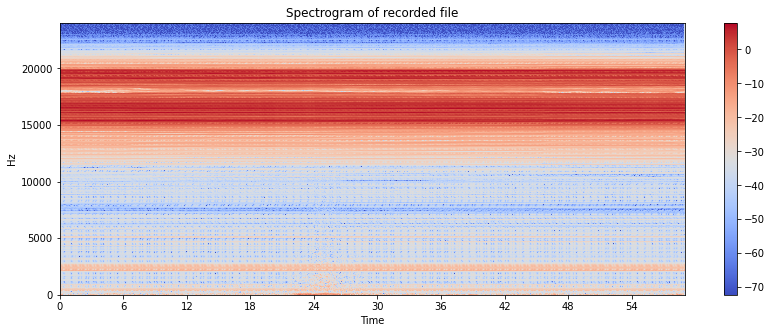

In [4]:
plot_frequency_time(records[0,:], SAMPLE_RATE, title='Spectrogram of recorded file')

# Extract distance and frequency

In [25]:
extract3d = Extract3D(one_chirp)
distance_time_specs, _, distance_freq = extract3d.preprocess(records) 
print(distance_time_specs.shape) # channel, no. of chirp, distance bin

(7, 2945, 1505)


# Heart rate

In [15]:
# seek heart rate from range 0.3-0.7 meters
min_distance = 0.3
max_distance = 0.7
specs_channel, hr_freq = extract3d.extract_heart_rate(distance_time_specs, distance_freq,
                           min_distance=min_distance, max_distance=max_distance,
                           from_time=0, to_time=SR*60)
print(specs_channel.shape)
print(hr_freq.shape)

(7, 36, 170)
(170,)


In [44]:
# coords where heart rate is detected
max_coords = [(peak_local_max(specs_channel[channel], min_distance=2,num_peaks=1)[0]) for channel in range(NO_CHANNEL)]


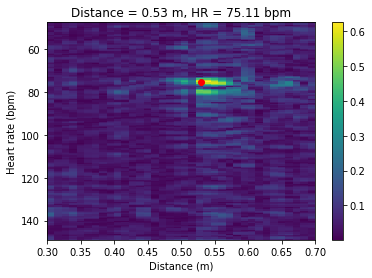

In [57]:
# plot channel 1
channel = 1
fig, ax = plt.subplots()
plt.rcParams["axes.grid"] = False
im = ax.imshow(np.transpose(specs_channel[channel]), interpolation='nearest', aspect='auto', 
                extent=[min_distance,max_distance, max(hr_freq)*60,min(hr_freq)*60])
plt.ylabel('Heart rate (bpm)')
plt.xlabel('Distance (m)')
fig.colorbar(im)

dist_idx, hr_idx = max_coords[channel]
detected_dist = freq_to_dist(distance_freq[dist_idx]) + min_distance
detected_hr = hr_freq[hr_idx]*60
plt.scatter(detected_dist, detected_hr, color='red')

plt.title(f'Distance = {detected_dist:.2f} m, HR = {detected_hr:.2f} bpm')

plt.show()  